#**Herramientas de econometría: Clase 2 Parte I**

##**Preparación del entorno**

Volvemos a importamos las librerías que necesitamos

In [1]:
import numpy as np                          # analisis numérico 
import pandas as pd                         # manejo de datos
import statsmodels.api as sm                # modelos estadísticos
import statsmodels.stats.api as sms         # módulo stats de statsmodels
import matplotlib.pyplot as plt             # gráficos básicos
import seaborn as sns                       # gráficos más avanzados
%matplotlib inline
plt.style.use("seaborn-white")

##**Importación y exploración de los datos**

Seguiremos trabajando con los datos que venimos utilizando de la primera clase, que eran datos de un ejemplo del libro de Gujarati y Porter (2010) guardados en el archivo GujaratiPorter71.txt. 

Importamos la base de datos en un data frame.

In [2]:
path = 'https://drive.google.com/uc?export=download&id=1jV5k9TcTpOzQT1l-hfOc5n617Lwh3-WV'
data = pd.read_csv(path, sep = " ", delimiter = "\t")

Revisamos que la importación haya sido exitosa

In [3]:
data.sample(6)

,CM,FLR,PGNP,TFR
1,204,22,130,6.15
54,79,43,1340,7.17
12,24,93,1730,3.50
11,129,55,900,5.99
5,209,26,200,6.44
3,197,65,570,6.25


Recordemos que los significados de estas variables eran son los siguientes:

* **CM**: child mortality (mortalidad infantil, fallecimientos en un año de niños menores a 5 años por cada 1000 nacidos vivos)
* **FLR**: female literacy rate (tasa de alfabetización de las mujeres)  
* **PGNP**: Per cápita Gross National Product (PIB per cápita en 1980)
* **TFR**: total fertility rate (tasa de fecundidad total)

##**Especificación y estimación**

En el ejemplo que venimos viendo nos interesa relacionar CM (mortalidad infantil) en función de FLR (tasa de alfabetización de las mujeres), PGNP (PIB per cápita) y TFR (tasa de fertilidad).

Para esto, volveremos a estimar el modelo por OLS, pero primero era recomendable asignar las variables a objetos. 

In [4]:
Y = data["CM"]
X = data[["FLR", "PGNP", "TFR"]]

Ahora sí volvamos a estimar nuestro modelo por OLS utilizando la función `OLS()` de la librería `statsmodels` para su especificación y los métodos `fit()` y `summary()` para la etimación y presentación de los resultados.

In [5]:
MiModelo = sm.OLS(Y, sm.add_constant(X))  # Construimos el modelo (agregando una constante con add_constant de Statsmodels)
Resultados = MiModelo.fit()               # Estimamos el modelo y guardamos los resultados
print(Resultados.summary())               # Mostramos los resultados

                            OLS Regression Results                            
Dep. Variable:                     CM   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     59.17
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           6.46e-18
Time:                        18:30:49   Log-Likelihood:                -323.43
No. Observations:                  64   AIC:                             654.9
Df Residuals:                      60   BIC:                             663.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        168.3067     32.892      5.117      0.0

Será necesario también que guardemos los residuos y los valores ajustados de este modelo porque muchos métodos que aplicaremos luego están basados en ellos.

In [6]:
Residuos = Resultados.resid                    # guardamos los residuos
Valores_ajustados = Resultados.predict()       # guardamos los valores ajustados

##**Diagnóstico: verificación de supuestos sobre el error**

Constatemos si la **media de los residuos** es próxima a **cero**.

In [7]:
np.mean(Residuos)

5.820899318109696e-13

El resultado está expresado en notación exponencial y muestra que la media de los residuos es prácticamente **cero**.

Otra alternativa para obtener este mismo resultado, en lugar de utilizar la función `mean()` de `numpy`, es recurrir a un método de la siguiente manera:

In [8]:
Residuos.mean()

5.820899318109696e-13

Por las dudas, examinemos también un gráfico de los residuos

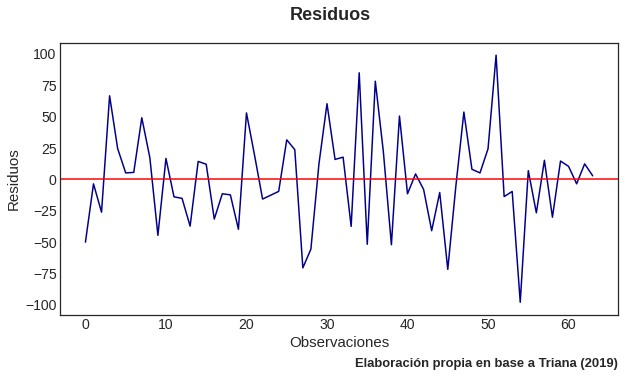

In [9]:
fig, ax = plt.subplots(figsize = (10,5))
fig.suptitle("Residuos", fontsize = 18, fontweight = "bold")
ax.plot(Residuos, color = "darkblue")
ax.set_xlabel("Observaciones", fontsize = 15)
ax.set_ylabel("Residuos", fontsize = 15)
ax.tick_params(labelsize = 14)
fig.text(.9,-.02, "Elaboración propia en base a Triana (2019)", fontsize = 13, fontweight = "bold", ha = "right")
plt.axhline(y=0,color='red')
plt.show()

Observar que los residuos se distribuyen por encima y por debajo del cero de manera más o menos uniforme.

###**Heteroscedasticidad**
Veamos ahora si se cumple el supuesto de **homoscedasticidad** o varianza constante del error.

Aprovechando el gráfico anterior de los residuos, en principio pareciera que la variabilidad no presenta grandes cambios, por lo cual no parece haber indicios de heteroscedasticidad.

Pero para tener más en cuenta la magnitud de los residuos, con independencia de sus signos, es más usual ver el gráfico de los residuos al cuadrado versus los valores ajustados del modelo para revisar si puede haber algún patrón o relación de dependencia.

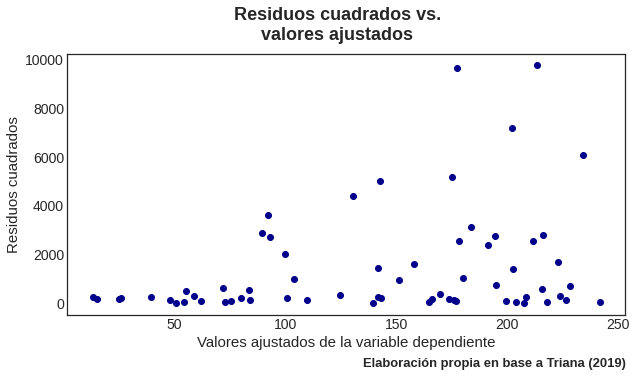

In [10]:
fig, ax = plt.subplots(figsize = (10,5))
fig.suptitle("Residuos cuadrados vs.\nvalores ajustados", fontsize = 18, fontweight = "bold")
ax.scatter(Valores_ajustados, Residuos**2, color = "darkblue")                  # ** es el operador potencia
ax.set_xlabel("Valores ajustados de la variable dependiente", fontsize = 15)
ax.set_ylabel("Residuos cuadrados", fontsize = 15)
ax.tick_params(labelsize = 14)
fig.text(.9,-.02, "Elaboración propia en base a Triana (2019)", fontsize = 13, fontweight = "bold", ha = "right")
plt.subplots_adjust(top = 0.85)
plt.show()

Observando este último gráfico, da la impresión de que la varianza se va incrementando a medida que aumentan los valores ajustados de la variable dependiente (que a su vez son función de las variables explicativas del modelo). Por lo tanto, tenemos un indicio de **posible heteroscedasticidad** que es conveniente revisar con algún contraste más formal.

Para esto podemos recurrir a un contraste general de heteroscedasticidad como es el test de **White**, que es una prueba de multiplicadores de Lagrange (LM test). Para llevar adelante este contraste tenemos la función `het_white()` de `statsmodels.stats`. Sus argumentos son los residuos del modelo y el conjunto de variables explicativas del modelo que, si el modelo tiene constante, es bueno tener guardado en un objeto (que volveremos a llamar exog).

In [11]:
exog = sm.add_constant(X)
ResultadosTestWhite = sms.het_white(Residuos, exog)       # Aplicamos el test y guardamos los resultados
Nombres = ["Estadístico LM", "p-value del estadístico LM", "Estadístico F", "p-value del estadístico F"]
pd.Series(ResultadosTestWhite, index = Nombres)           # Presentamos los resultados de una manera más ordenada

Estadístico LM                7.253524
p-value del estadístico LM    0.610742
Estadístico F                 0.766940
p-value del estadístico F     0.646936
dtype: float64

Los resultados no muestran evidencia de heteroscedasticidad y permiten mantener el supuesto de homoscedasticidad. No obstante, como es un test demasiado general, podríamos probar también alguno más específico.

Una posibilidad es aplicar el contraste de **Breusch-Pagan**, que también es un **LM test** y que en Python se puede aplicar con la función `het_breuschpagan()` de `statsmodels.stats`. Igual que vimos con la función del test de White, entre los argumentos esta función necesita los residuos y las variables explicativas del modelo que podrían ser responsables de la heteroscedasticidad. Como nosotros no sospechamos de ninguna en particular, podemos incluirlas a todas que ya las teníamos guardadas en el objeto exog.

In [12]:
ResultadosTestBP = sms.het_breuschpagan(Residuos, exog)    # Aplicamos el test y guardamos los resultados
pd.Series(ResultadosTestBP, index = Nombres)               # Presentamos los resultados de una manera más ordenada

Estadístico LM                6.353684
p-value del estadístico LM    0.095615
Estadístico F                 2.204368
p-value del estadístico F     0.096831
dtype: float64

Los resultados no son demasiado concluyentes porque con una significación del 5% indican que no habría heteroscedasticidad, pero con una significación del 10% sí. Por lo tanto, podría presentarse una violación al supuesto de homoscedasticidad.

Dado lo que habíamos observado en el gráfico (varianza probablemente creciente), resulta útil también probar el contraste de **Goldfeld-Quandt**.

In [13]:
ResultadosTestGQ = sms.het_goldfeldquandt(Y, exog, drop = 0.33)   
# observar que a diferencia de los anteriores, requiere como argumentos la variable endógena y las regresoras exógenas
# la opción drop indica que porción del centro es descarta
# está disponible también la opción alternative con “increasing”, “decreasing”, “two-sided” para distintos tipos de heteroscedasticidad
# por defecto prueba "increasing"
Nombres = ["Estadístico F", "p-value", "Hipótesis alternativa"]   
pd.Series(ResultadosTestGQ, index = Nombres)

Estadístico F              0.944458
p-value                      0.5852
Hipótesis alternativa    increasing
dtype: object

Afortunadamente, los resultados señalan que no se rechaza la hipótesis nula de homoscedasticidad.

Ante la duda, o si hubiéramos encontrado evidencia de heteroscedasticidad, una forma bastante sencilla de corregir el problema es estimando nuestro modelo con **errores estándares robustos**. Esto se consigue aplicando el método `get_robustcov_results()` sobre nuestro objeto creado con la función `OLS()`

In [14]:
Resultados_robustos = Resultados.get_robustcov_results()
print(Resultados_robustos.summary())

                            OLS Regression Results                            
Dep. Variable:                     CM   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     93.27
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           1.46e-22
Time:                        18:33:53   Log-Likelihood:                -323.43
No. Observations:                  64   AIC:                             654.9
Df Residuals:                      60   BIC:                             663.5
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        168.3067     33.429      5.035      0.0

Si comparamos esta última salida con la de nuestro modelo originalmente estimado por OLS, notaremos que los coeficientes estimados son los mismos, pero que han cambiado las estimaciones de los errores estándar. Ahora son estimaciones robustas frente a heteroscedasticidad.

Los errores estándar estimados por defecto con este método son los tipo HC1. Las diferencias no son demasiado importantes con otros métodos de estimación robusta, como puede verse si armamos una tabla como la siguiente.

In [15]:
pd.DataFrame({'HC0':Resultados.HC0_se, 'HC1':Resultados.HC1_se, 'HC2':Resultados.HC2_se, 'HC3':Resultados.HC3_se})

,HC0,HC1,HC2,HC3
const,32.367698,33.429214,33.587382,34.887573
FLR,0.245067,0.253104,0.253279,0.263717
PGNP,0.000762,0.000787,0.001217,0.002314
TFR,4.064170,4.197456,4.224024,4.395384


###**Autocorrelación**

Otro supuesto importante para verificar es la ausencia de **autocorrelación** entre las perturbaciones. La autocorrelación, o correlación serial, es un problema mucho más frecuente en series de tiempo, pero si los datos son de corte transversal y fueron obtenidos en determinado orden, también podrían tenerlo presente.

Los resultados del contraste más clásico de autocorrelación, el test de **Durbin-Watson**, que sólo prueba correlación de primer orden, se puede ver directamente en la salida de nuestro modelo estimado por OLS.

In [16]:
print(Resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                     CM   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     59.17
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           6.46e-18
Time:                        18:33:53   Log-Likelihood:                -323.43
No. Observations:                  64   AIC:                             654.9
Df Residuals:                      60   BIC:                             663.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        168.3067     32.892      5.117      0.0

Como podemos observar, el resultado del estadístico de Durbin-Watson que obtuvimos está muy cerca de 2. Por lo tanto, no hay indicios de autocorrelación.

Si queremos exponer aparte el resultado de este contraste, podemos usar la función `durbin_watson()` de `statsmodels.stats`

In [17]:
ResultadosTestDW = sms.durbin_watson(Residuos)
Nombres = ["Estadístico DW"]
pd.Series(ResultadosTestDW, index = Nombres)

Estadístico DW    2.170318
dtype: float64

El problema, en ambos tipos de presentaciones, es que los resultados no vienen con algún p-value. Esto es porque el estadístico DW no tiene un único valor crítico para cada posible combinación de parámetros (tamaño de muestra y cantidad de variables explicativas excluyendo la constante), sino dos límites (dL y dU) que encierran áreas de indecisión. Se pueden consultar las tablas de DW y decidir con mayor precisión, pero en la práctica lo más usual es ver dónde se ubica el resultado del estadístico dentro del rango que va de 0 a 4.

Para tener una salida mucho más completa y también probar autocorrelación de órdenes superiores podemos utilizar el test de **Breusch-Godfrey** que en Python se puede aplicar con la función `acorr_breusch_godfrey()` de `statsmodels.stats`. Como argumentos requiere los resultados del modelo (no los residuos, cuidado con esto) y el número de lags (rezagos) que queremos contrastar.

In [18]:
ResultadosTestBG1 = sms.acorr_breusch_godfrey(Resultados, nlags = 1)             # probamos primero autocorrelación de orden 1
Nombres = ["Estadístico LM", "p-value del estadístico LM", "Estadístico F", "p-value del estadístico F"]
pd.Series(ResultadosTestBG1, index = Nombres)

Estadístico LM                0.640626
p-value del estadístico LM    0.423484
Estadístico F                 0.596548
p-value del estadístico F     0.442981
dtype: float64

No se rechaza la hipótesis nula de independencia serial (no autocorrelación) de primer orden. No habiendo autocorrelación de primer orden, difícilmente haya de órdenes superiores (excepto tal vez en series estacionales), pero veamos lo simple que sería poner a prueba, por ejemplo, la autocorrelación hasta de orden 4.

In [19]:
ResultadosTestBG4 = sms.acorr_breusch_godfrey(Resultados, nlags = 4)            # probamos autocorrelación hasta de orden 4
pd.Series(ResultadosTestBG4, index = Nombres)

Estadístico LM                2.178171
p-value del estadístico LM    0.703028
Estadístico F                 0.493263
p-value del estadístico F     0.740668
dtype: float64

Como era de esperar, menos prueba hay aún de autocorrelación de órdenes superiores.

Si quisiéramos aplicar los test de **Box-Pierce** o **Ljung-Box**, podemos usar la función `acorr_ljungbox()` de `statsmodels.stats`

In [20]:
ResultadosTestLB = sms.acorr_ljungbox(Residuos, lags = 2, boxpierce = True)     # el argumento boxpierce = True permite agregar los resultados de Box-Pierce
Nombres = ["Estadístico LB", "p-value del estadístico LB", "Estadístico BP", "p-value del estadístico BP"]
pd.Series(ResultadosTestLB, index = Nombres)

/home/adalisa/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Estadístico LB                 [0.6565780403888075, 0.6566908454821845]
p-value del estadístico LB    [0.41777062943072274, 0.7201142329072359]
Estadístico BP                 [0.6267335840074981, 0.6268395524285493]
p-value del estadístico BP    [0.42855599423865787, 0.7309430156674115]
dtype: object

Notar que a diferencia del test de Breusch-Godfrey, estos contrastes de Box-Pierce y Ljung-Box van probando de manera sucesiva la autocorrelación de órdenes superiores y arrojando tanto los estadísticos como los p-values de cada orden. 

En este ejemplo claramente no hay evidencia alguna de autocorrelación.

###**Normalidad**

La prueba de normalidad más clásica en econometría, el test de **Jarque-Bera**, ya viene en la salida de nuestro modelo estimado por OLS.

In [21]:
print(Resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                     CM   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     59.17
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           6.46e-18
Time:                        18:33:55   Log-Likelihood:                -323.43
No. Observations:                  64   AIC:                             654.9
Df Residuals:                      60   BIC:                             663.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        168.3067     32.892      5.117      0.0

Pero si queremos resultados más completos de esta prueba, incluidos los coeficientes de asimetría y curtosis, podemos utilizar el siguiente código.

In [22]:
ResultadosTestJB = sms.jarque_bera(Residuos)
Nombres = ["Jarque-Bera", "p-value", "Asimetría", "Curtosis"]
pd.Series(ResultadosTestJB, index = Nombres)

Jarque-Bera    0.509408
p-value        0.775146
Asimetría      0.145068
Curtosis       3.326877
dtype: float64

Observar que el p-value supera ampliamente los niveles de significación usuales. Por lo tanto, no se rechaza la hipótesis de normalidad.

A conclusión similar podemos arribar observando los valores de los coeficientes de asimetría (cercano a 0) y curtosis (cercano a 3).

La salida de nuestro modelo estimado por OLS también incluye los resultados del test **omnibus** o **$K^2$ de D´Agostino**. Si queremos exponer su resultado de una manera más elegante podemos hacer... 

In [23]:
ResultadosTestK2 = sms.omni_normtest(Residuos)
Nombres = ["Estadístico K2", "p-value"]
pd.Series(ResultadosTestK2, index = Nombres)

Estadístico K2    1.102902
p-value           0.576113
dtype: float64

Otra prueba de normalidad que se usa mucho en econometría, también en estadística en general, es la de **Kolmogorov-Smirnov**.

In [24]:
ResultadosTestKS = sms.diagnostic.kstest_normal(Residuos)
Nombres = ["Estadístico KS", "p-value"]
pd.Series(ResultadosTestKS, index = Nombres)

Estadístico KS    0.105760
p-value           0.096427
dtype: float64

Observar que aquí los resultados no son demasiado concluyentes. A un 5% de significación no rechaza la normalidad, pero sí lo hace para niveles mayores a 7,26%. 

Podemos probar también el test de **Shapiro-Wilk**, que es más específico para normalidad que Kolmogorov-Smirnov.

In [25]:
from scipy.stats import shapiro               # importamos la función shapiro de la librería scipy
ResultadosTestSW = shapiro(Residuos)
Nombres = ["Estadístico SW", "p-value"]
pd.Series(ResultadosTestSW, index = Nombres)

Estadístico SW    0.982833
p-value           0.514986
dtype: float64

Si quisiéramos explorar un poco más el supuesto de normalidad con **métodos gráficos**, podemos podemos visualizar la distribución empírica de los residuos versus la distribución teórica de una normal.

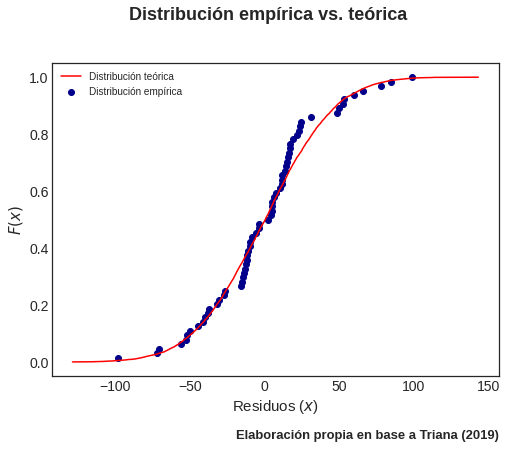

In [26]:
# Primero armamos la función de distribución de nuestros residuos
x = np.sort(Residuos)              # ordenamos los residuos
n = x.size                         # tamaño total de la muestra
y = np.arange(1, n+1) / n          # calculamos las probabilidades acumuladas por cada valor observado en orden

# Luego obtenemos la función de distribución teórica de una normal
Residuos_teoricos = np.random.normal(loc = np.mean(Residuos),   # obtenemos una muestra aleatoria proveniente de una 
                    scale = np.std(Residuos), size = 10000)     # distribución normal con la media y desv.est. de nuestros residuos
x_teor = np.sort(Residuos_teoricos)       # ordenamos la muestra aleatoria
n_teor = x_teor.size                      # guardamos el tamaño de esta muestra
y_teor = np.arange(1, n_teor+1) / n_teor  # calculamos las probabilidades acumuladas por sus valores

# Por último, superponemos ambas distribuciones en un mismo gráfico
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Distribución empírica vs. teórica", fontsize = 18, fontweight = "bold")
ax.scatter(x, y, color = "darkblue", label = "Distribución empírica")
ax.plot(x_teor, y_teor, color = "red", label = "Distribución teórica")
ax.set_xlabel("Residuos ($x$)", fontsize = 15)
ax.set_ylabel("$F(x)$", fontsize = 15)
ax.tick_params(labelsize = 14)
ax.legend()
fig.text(.9,-.02, "Elaboración propia en base a Triana (2019)", fontsize = 13, fontweight = "bold", ha = "right")
plt.subplots_adjust(top = 0.85)
plt.show()

Observar que los puntos azules (distribución empírica) no se alejan demasiado de la curva roja (distribución teórica). Por lo tanto, no parece haber un problema serio de falta de normalidad.

También podemos revisar un QQ plot

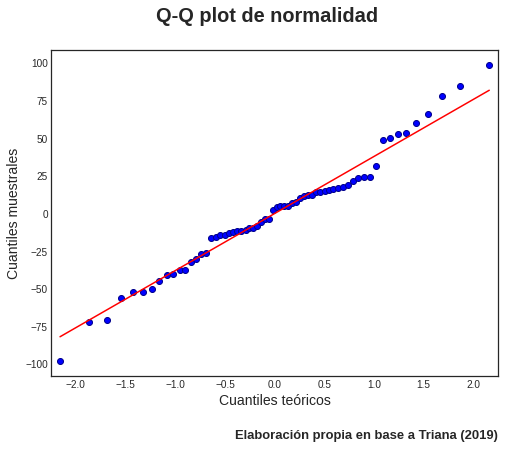

In [27]:
fig, ax = plt.subplots(figsize = (8,6))
fig.suptitle("Q-Q plot de normalidad", size = 20, fontweight = "bold")
sm.qqplot(Residuos, ax = ax, line = "s", color = "darkblue")
ax.set_xlabel("Cuantiles teóricos", fontsize = 14)
ax.set_ylabel("Cuantiles muestrales", fontsize = 14)
fig.text(.9,-.02, "Elaboración propia en base a Triana (2019)", fontsize = 13, fontweight = "bold", ha = "right")
plt.show()

La mayoría de los cuantiles muestrales (puntos azules) no se alejan demasiado de los teóricos (línea roja). La distribución de los residuos parece aproximarse bien a una normal.